In [89]:
 #Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-20 16:26:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-03-20 16:26:34 (6.57 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’ saved [178509/178509]



In [90]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [91]:
# Load dataset
prices_raw_df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
prices_raw_df.head()

Currency        Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC  2013-10-01            123.65499       124.30466       124.75166   
1      BTC  2013-10-02            125.45500       123.65499       125.75850   
2      BTC  2013-10-03            108.58483       125.45500       125.66566   
3      BTC  2013-10-04            118.67466       108.58483       118.67500   
4      BTC  2013-10-05            121.33866       118.67466       121.93633   

   24h Low (USD)  
0      122.56349  
1      123.63383  
2       83.32833  
3      107.05816  
4      118.00566

In [92]:
prices = pd.DataFrame({"date":prices_raw_df['Date'],
                       "price":prices_raw_df['Closing Price (USD)']})
prices.head()

date      price
0  2013-10-01  123.65499
1  2013-10-02  125.45500
2  2013-10-03  108.58483
3  2013-10-04  118.67466
4  2013-10-05  121.33866

<Axes: >

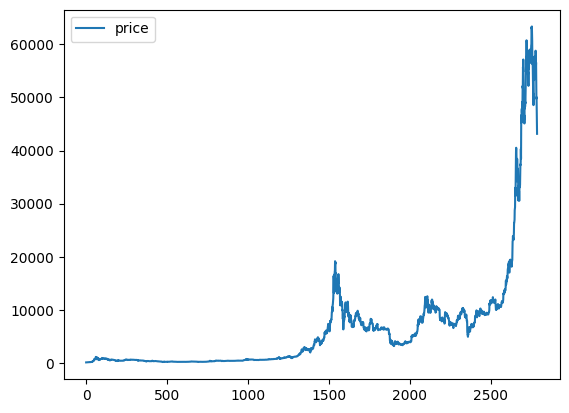

In [93]:
prices.plot()

In [94]:
split_time = 2000
time = prices['date'].to_numpy(dtype='datetime64[ns]')
series = prices['price'].to_numpy()

len(time), len(series), time[:2], series[:2]

(2787,
 2787,
 array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  ]))

In [95]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


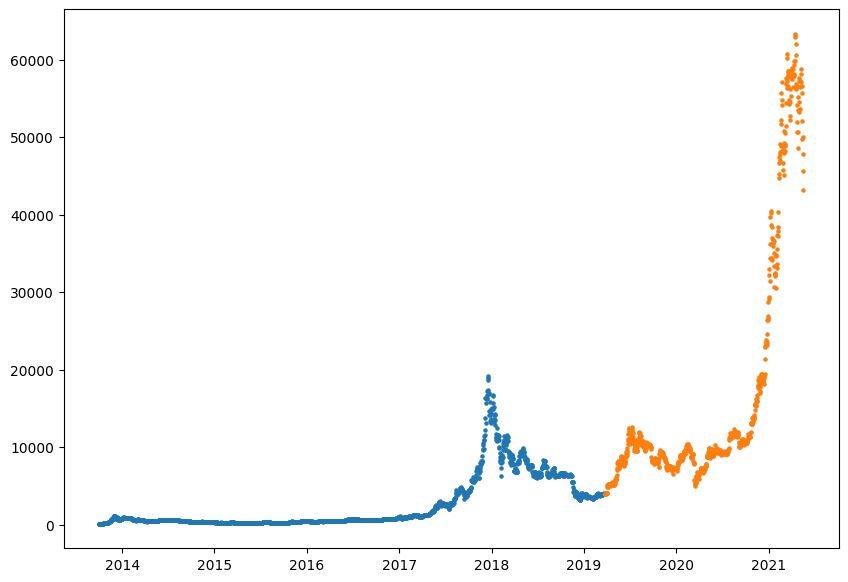

In [96]:
plt.figure(figsize=(10,7))
plt.scatter(time_train, x_train, s=5)
plt.scatter(time_valid, x_valid, s=5)

In [97]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [98]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [99]:
def get_lstm_model():
  model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, activation="relu", input_shape=(None,1)),
  tf.keras.layers.Dense(1),
  ])
  return model

In [100]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 7
train_set = window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128,  activation="relu",input_shape=(None, 1)),
  tf.keras.layers.Dense(1)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
63/63 [==============================] - 2s 12ms/step - loss: 3187.1704 - mae: 3187.1704 - lr: 1.0000e-06
Epoch 2/100
63/63 [==============================] - 1s 12ms/step - loss: 3174.1621 - mae: 3174.1621 - lr: 1.1220e-06
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 3166.2854 - mae: 3166.2854 - lr: 1.2589e-06
Epoch 4/100
63/63 [==============================] - 1s 12ms/step - loss: 3157.3496 - mae: 3157.3496 - lr: 1.4125e-06
Epoch 5/100
63/63 [==============================] - 1s 12ms/step - loss: 3150.1172 - mae: 3150.1172 - lr: 1.5849e-06
Epoch 6/100
63/63 [==============================] - 1s 12ms/step - loss: 3139.1865 - mae: 3139.1865 - lr: 1.7783e-06
Epoch 7/100
63/63 [==============================] - 1s 12ms/step - loss: 3123.3396 - mae: 3123.3396 - lr: 1.9953e-06
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 3116.9695 - mae: 3116.9695 - lr: 2.2387e-06
Epoch 9/100
63/63 [==============================] - 1s 

(1e-05, 0.001, 0.0, 1500.0)

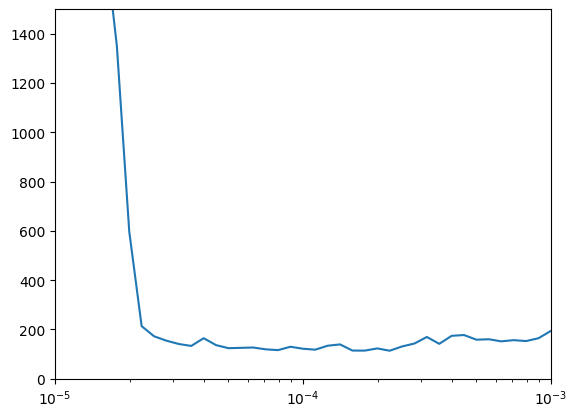

In [101]:
plt.semilogx(history.history["lr"], history.history["loss"], label="lr vs epoch")
plt.axis([1e-5, 1e-3, 0, 1500])

In [102]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 7
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128,activation="relu", input_shape=(None,1)),
  tf.keras.layers.Dense(1)
  ])
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
63/63 [==============================] - 3s 20ms/step - loss: 2363.9265 - mae: 2363.9265 - val_loss: 15185.9180 - val_mae: 15185.9180


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
63/63 [==============================] - 1s 17ms/step - loss: 2233.3401 - mae: 2233.3401 - val_loss: 14542.4678 - val_mae: 14542.4678
Epoch 3/500
63/63 [==============================] - 1s 15ms/step - loss: 2039.9515 - mae: 2039.9515 - val_loss: 12593.0010 - val_mae: 12593.0010
Epoch 4/500
63/63 [==============================] - 1s 18ms/step - loss: 1083.4801 - mae: 1083.4801 - val_loss: 3867.3076 - val_mae: 3867.3076
Epoch 5/500
63/63 [==============================] - 2s 26ms/step - loss: 288.5976 - mae: 288.5976 - val_loss: 1367.0159 - val_mae: 1367.0159
Epoch 6/500
63/63 [==============================] - 1s 20ms/step - loss: 200.5040 - mae: 200.5040 - val_loss: 1461.8411 - val_mae: 1461.8411
Epoch 7/500
63/63 [==============================] - 1s 17ms/step - loss: 202.3688 - mae: 202.3688 - val_loss: 935.2607 - val_mae: 935.2607
Epoch 8/500
63/63 [==============================] - 1s 16ms/step - loss: 173.7071 - mae: 173.7071 - val_loss: 891.2394 - val_mae: 891.2394


In [103]:
model = tf.keras.models.load_model('my_checkpoint.h5')

In [104]:
model.evaluate(valid_set)

25/25 [==============================] - 0s 6ms/step - loss: 518.6747 - mae: 518.6747


[518.6747436523438, 518.6747436523438]

In [105]:
forecast = model_forecast(model, series[split_time - window_size : -1 ], window_size)[:,0]

25/25 [==============================] - 0s 8ms/step


In [106]:
len(forecast), len(x_valid)

(787, 787)

In [107]:
tf.keras.metrics.mean_absolute_error(x_valid[window_size:], forecast[window_size:]).numpy()

518.6747

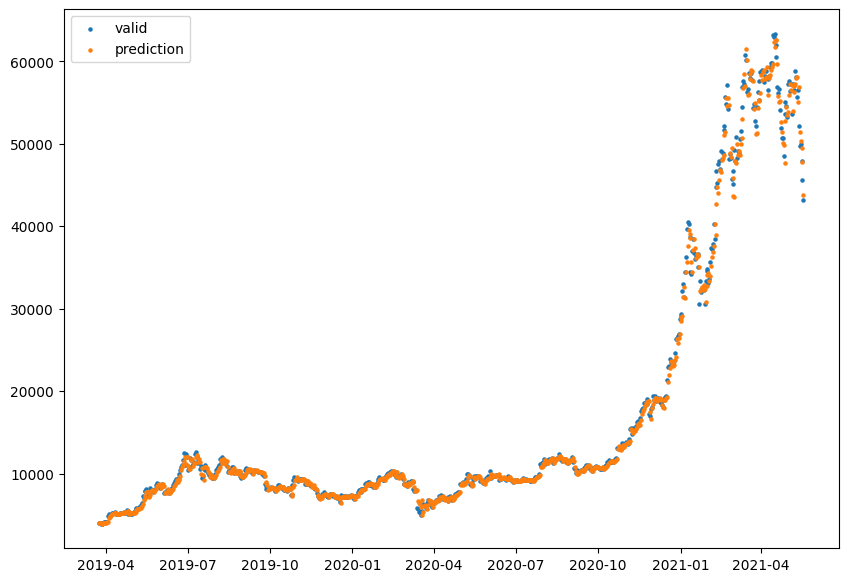

In [108]:
plt.figure(figsize=(10,7))
plt.scatter(time_valid, x_valid, s=5, label='valid')
plt.scatter(time_valid, forecast, s=5, label='prediction')
plt.legend()